CSCI P-556: Applied Machine Learning

Fall 2019

Assignment 4

Due: 11:59PM, December 6, 2019

Read dataset

In [0]:
import pandas as pd
train = pd.read_csv('a4-train.csv', index_col=0)
test = pd.read_csv('a4-test.csv', index_col=0)

Task 1: Perform exploratory data analysis (15 points)

In [6]:
print('Train Data:',train.shape)
print('Test Data:',test.shape)

Train Data: (2000, 501)
Test Data: (600, 501)


Distribution of dep variable

In [7]:
print('Train Data')
print(train['labels'].value_counts())

print('Test Data')
print(test['labels'].value_counts())

Train Data
1    1000
0    1000
Name: labels, dtype: int64
Test Data
1    300
0    300
Name: labels, dtype: int64


***looks like the distribution of dependent variable is balanced***

Check for null

In [8]:
null_df = pd.DataFrame(pd.isnull(train).sum() > 0, columns =['is_null'])

null_df[null_df['is_null'] == True ]

,is_null


***Data has no null values***

Correlation Matrix

ref - https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57

comments - *Plot may not be visible in all monitors*


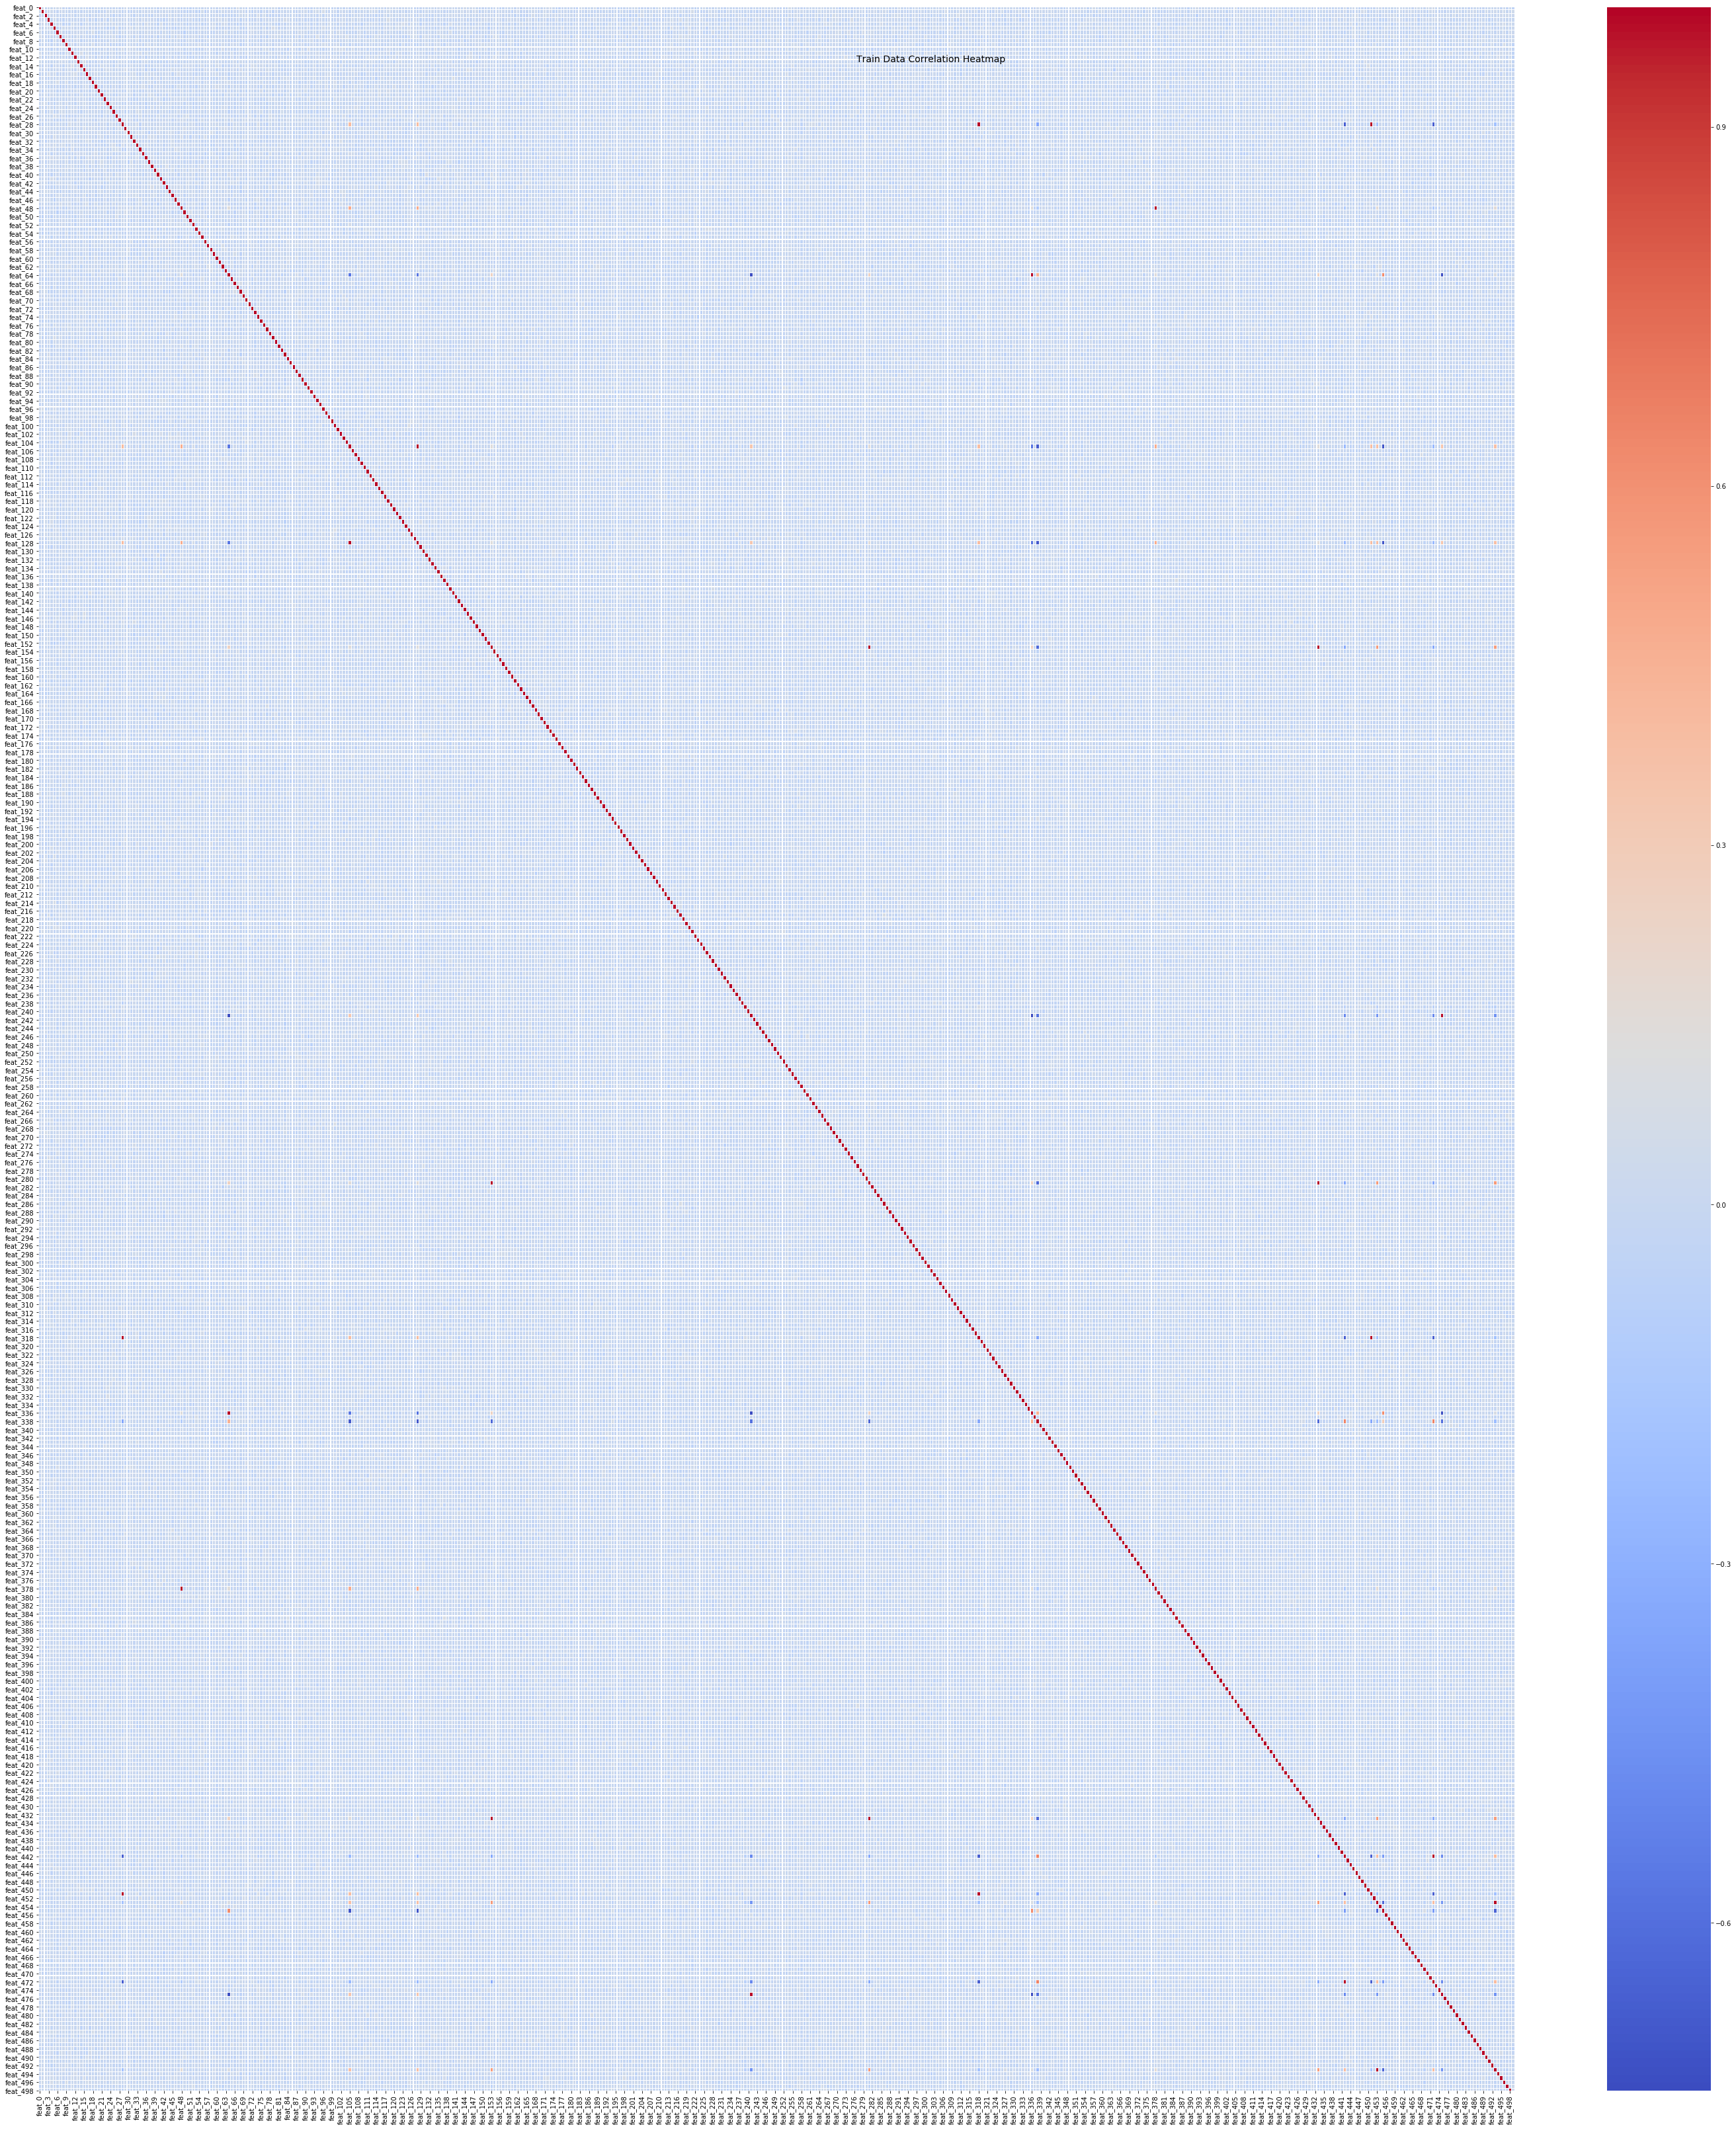

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

f, ax = plt.subplots(figsize=(50, 50))
corr = train.corr()
hm = sns.heatmap(round(corr.iloc[list(range(500)),list(range(500))],2), 
                 annot=False, 
                 ax=ax, 
                 cmap="coolwarm",
                 fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=1)
t = f.suptitle('Train Data Correlation Heatmap', fontsize=14)

In [0]:
corr.to_csv('./correlation_mat.csv')

***Although we can see there is some correlation between a few of the independent variables, most of the independent variables are uncorrelated***

PCA to reduce dimensions

ref - https://www.analyticsvidhya.com/blog/2016/03/practical-guide-principal-component-analysis-python/

Text(0.5, 1.0, 'Cumulative Scree Plot')

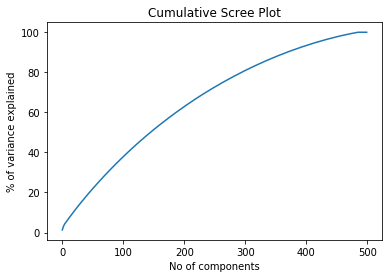

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
import matplotlib.pyplot as plt
X = train.values
scaled_X = scale(X)

pca = PCA(n_components=500)
pca.fit(scaled_X)

var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(var, decimals=4)*100)
plt.plot(var1)
plt.xlabel('No of components')
plt.ylabel('% of variance explained')
plt.title('Cumulative Scree Plot')

***From the cummulative scree plot above we try to see the % of variance captured as we vary the number of principal components. We can observe that we can't reduce the dimensionality of the data to say 100 dimensions because 100 components cummulatively capture only 40% of the variance***

TSNE to reduce dimensions

ref - https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

Cummulative explained variation for 400 principal components: 0.9300949626644837


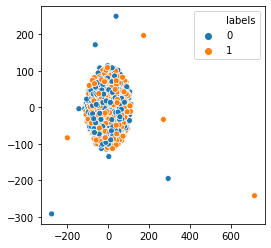

In [12]:
from sklearn.manifold import TSNE
import seaborn as sns
%matplotlib inline

pca_400 = PCA(n_components=400)
pca_result_400 = pca_400.fit_transform(scaled_X)
print('Cummulative explained variation for 400 principal components: {}'.\
      format(np.sum(pca_400.explained_variance_ratio_)))

tsne = TSNE(n_components=3)
tsne_results = tsne.fit_transform(pca_result_400)

plt.figure(figsize=(4,4))
sns.scatterplot(
    x= tsne_results[:, 0], y = tsne_results[:,1],
    hue=train['labels']
)

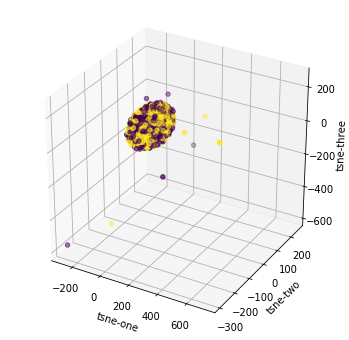

In [13]:
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure(figsize=(6,6)).gca(projection='3d')
ax.scatter(
    xs = tsne_results[:, 0],
    ys = tsne_results[:, 1], 
    zs = tsne_results[:, 2], 
    c = train['labels'], 
    # cmap='BrBG'
)
ax.set_xlabel('tsne-one')
ax.set_ylabel('tsne-two')
ax.set_zlabel('tsne-three')
plt.show()

***Looks like the the 500D data cannot be easily decomposed into lower dimension using PCA. 400 PCA components explains 90% of the variance. If we try to visualize the 400 components in 2D using TSNE the data is not separable. Even in 3D space the data is not separable***

Task 2: Use scikit-learn's logistic regression to establish a baseline model. We are not expecting this model to perform well, we just want to know what is the highest accuracy that we can achieve without doing any feature engineering and/or parameter tuning. (5 points)

Split Data

In [0]:
x_train = train.loc[:, train.columns != 'labels']
y_train = train.loc[:,'labels']
x_test = test.loc[:, train.columns != 'labels']
y_test = test.loc[:,'labels']

Baseline Model

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(solver= 'liblinear')
model = lr.fit(x_train, y_train)
predictions = model.predict(x_test)
print('Test Accuracy:', accuracy_score(y_test, predictions))

Test Accuracy: 0.59


***Baseline logistic model without any feature engineering or parameter tuning gives a test accuracy of 59%***

Task 3: Feature engineering. On this task you'll write code to modify your features such that the model can achieve a higher accuracy. You are free to modify the data as you want, but a rationale has to be provided for each modification. Additionally, if you are using anything that has not been convered in class, write a brief description of how the function works. Note that copy/pasting a function's docstring is not what we are asking and we will take off points if this is what you do. (20 points)

***In our EDA we saw that we can not reduce the dimensionality of the data easily because lower number of principal components do not capture a great % of the variance in the data. We cannot create new features easily as well as part of feature engineering because we do not have any domain knowledge of the data. So what we can do instead is we can look at the importance of each feature as a feature selection step. The reason why feature selection is important is because it will help us decide on the best features, reduce training time, reduce possibility of overfitting and improve accuracy*** 

Univariate Feature Selection using Chi-Squared statistic

ref - https://machinelearningmastery.com/feature-selection-machine-learning-python/

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

K = 10
chisqtest = SelectKBest(score_func=chi2, k=K)
fit = chisqtest.fit(x_train, y_train)

scores = fit.scores_
indices = np.argsort(scores)[::-1]
print("Feature ranking:")

for f in range(K):
    print("%d. %s (%f)" % (f + 1, train.columns[indices[f]], 
                           scores[indices[f]]))

top_K_1 = train.columns[indices[:K]]

Feature ranking:
1. feat_105 (1149.161999)
2. feat_475 (1103.964772)
3. feat_336 (1045.121608)
4. feat_64 (724.889838)
5. feat_493 (592.569440)
6. feat_338 (556.906380)
7. feat_241 (547.844806)
8. feat_442 (499.042462)
9. feat_453 (487.976320)
10. feat_378 (182.461971)


***Here we calculate the chi-squared statistic independently for each variable. The chi-squared statistic $\chi = \sum \frac{{(O_i - E_i)}^2}{E_i} $tells us whether there is a difference between the expected and observed value of a continuous variable wrt the categorical/dependent variable. The function returns chi-squared statistic score for each variable where higher score implies there is strong relationship between the continuous variable and the dependent variable. We can then select the top k variables based on this score.***

Recursive Feature Elimination - Cross Validation

https://www.quora.com/scikit-learn-How-does-RFECV-make-use-of-cross-validation

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV

In [17]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100)
rfe = RFECV(model, step = 5, cv = 3, verbose = 2)
fit = rfe.fit(x_train, y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % x_train.columns[fit.support_])
# print("Feature Ranking: %s" % fit.ranking_)
top_K_2 = x_train.columns[fit.support_]

Fitting estimator with 500 features.
Fitting estimator with 495 features.
Fitting estimator with 490 features.
Fitting estimator with 485 features.
Fitting estimator with 480 features.
Fitting estimator with 475 features.
Fitting estimator with 470 features.
Fitting estimator with 465 features.
Fitting estimator with 460 features.
Fitting estimator with 455 features.
Fitting estimator with 450 features.
Fitting estimator with 445 features.
Fitting estimator with 440 features.
Fitting estimator with 435 features.
Fitting estimator with 430 features.
Fitting estimator with 425 features.
Fitting estimator with 420 features.
Fitting estimator with 415 features.
Fitting estimator with 410 features.
Fitting estimator with 405 features.
Fitting estimator with 400 features.
Fitting estimator with 395 features.
Fitting estimator with 390 features.
Fitting estimator with 385 features.
Fitting estimator with 380 features.
Fitting estimator with 375 features.
Fitting estimator with 370 features.
F

***Another way to select the top k features is using Recursive Feature Elimination with Cross Validation(RFECV). What this function does is it recursively drops fixed number of features based on some metric (coefficients for linear models/feature importance for tree based models). At each recursive step it calculates the cross validation accuracy. It finally returns the set of features which gave the highest cross validation accuracy across the set number of folds. The advantage of this method is that we don't have to set the value of number of features k***

Feature Importance

ref - https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(x_train, y_train)
importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#              axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

num_features = K
# num_features = x_train.shape[1]
for f in range(num_features):
    print("%d. %s (%f)" % (f + 1, train.columns[indices[f]], importances[indices[f]]))

top_K_3 = train.columns[indices[:num_features]]

Feature ranking:
1. feat_475 (0.011177)
2. feat_241 (0.009266)
3. feat_338 (0.007439)
4. feat_442 (0.006255)
5. feat_105 (0.006179)
6. feat_128 (0.006133)
7. feat_336 (0.005954)
8. feat_472 (0.005805)
9. feat_48 (0.005540)
10. feat_378 (0.005334)


Ref- https://towardsdatascience.com/an-intuitive-explanation-of-random-forest-and-extra-trees-classifiers-8507ac21d54b

https://medium.com/@hiromi_suenaga/machine-learning-1-lesson-6-14bbb8180d49

***To calculate the important features we can use feature importance from extra tree classifier model. Extra tree classifier is an extremely randomized version of Random Forest. The key differences are -***
*   in random forest we use bootstrap sample for each individual decision tree, whereas for extra tree classifier each individual decision tree uses all the data samples
* in random forest after a feature is selected the split is made at optimal cutting point whereas in extra tree classifier the splits are made randomly.

\\***An intuitive way to understand how it calculates importance is once the forest is trained on all the variables - the algorithm checks how randomly shuffling the values of a particular variable impacts the results of the model. The feature for which this shuffling resulted in the worst result as compared to the result with no-shuffling is the most importance.***

Task 4: Model building & evaluation. Train at least 4 models:


1.   Neural network (any type of NN is fine)
2.   Decision tree (can be a plain decision tree, random forest, gradient boosted trees, etc.)
3.   Support vector machine
4.   Your choice of Naive Bayes or K-nearest neighbors

For model 4, briefly (no more than 2 paragraphs) describe how the model works. 

Part of your grade will depend on how your best model performs against the best model of all the classmates, as determined by the accuracy achieved using the test set. You are encouraged to share your best model's accuracy on Piazza, but not which feature engineering or model tuning steps you took to achieve it. (60 points)

***Now that we have the top K best features from different feature selection techniques, we can use these features with different classifiers to check which classsifier gives best accuracy on the test set. We built two feature subsets from the results of the feature selection***
* Subset 1 - Top features from RFECV
* Subset 2 - Union of top features from select k best and feature importances using ExtraTreeClassifier
*italicized text*




In [0]:
# Feature subset 1
subset_1 = list(top_K_2)

In [0]:
# Feature subset 2
subset_2 = list(set(list(top_K_1) + list(top_K_3)))


Neural Network (Test Accuracy 75%)

In [0]:
# hidden_layer_grid = []
# neurons = [10, 20, 30, 40, 50]
# for n in range(2, 6):
#    for combination in itertools.product(neurons, repeat = n):
#      hidden_layer_grid.append(combination)

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

random_grid = {'hidden_layer_sizes': [(40,40,40,40,)],
               'max_iter': [300],
               'solver': ['adam'],
               'activation': ['relu'],
               'learning_rate_init': [0.001],
               'learning_rate': ['constant']}

print('---------------Randomized Grid Params---------------')
# pprint(random_grid)

net = MLPClassifier()
print('---------------Randomized Grid Search---------------')
net_random = RandomizedSearchCV(estimator = net, 
                               param_distributions = random_grid, 
                               n_iter = 1, 
                               cv = 3, 
                               verbose = 3, 
                               random_state = 42, 
                               n_jobs = -1,
                              return_train_score = True)


## SELECT SUBSET OF TOP K FEATURES##
top_K = subset_1 # or subset_2

net_random.fit(x_train.loc[:, top_K], y_train)
print('---------------Best Params from Random Search----------------')
pprint(net_random.best_params_)

print('---------------Results from Best MLP model-----------------------')
best_random = net_random.best_estimator_
predictions = best_random.predict(x_test.loc[:, top_K])
print('Test Accuracy:', accuracy_score(y_test, predictions))

---------------Randomized Grid Params---------------
---------------Randomized Grid Search---------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished


---------------Best Params from Random Search----------------
{'activation': 'relu',
 'hidden_layer_sizes': (40, 40, 40, 40),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 300,
 'solver': 'adam'}
---------------Results from Best MLP model-----------------------
Test Accuracy: 0.75


Random Forest (Test Accuracy 90% ***Best Model***)

ref - https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=100,
                            random_state=  0,
                            verbose = 1)
print('Parameters currently in use:')
pprint(rf.get_params())

## SELECT SUBSET OF TOP K FEATURES##
top_K = subset_1 # or subset_2

print('--------------K-Fold Cross Validation--------------')
scores = cross_val_score(rf, x_train.loc[:, top_K], y_train, cv = 3)

print('--------------Model Training--------------')
rf.fit(x_train.loc[:,top_K], y_train)
print('Done...')

predictions = rf.predict(x_test.loc[:, top_K])
print('--------------Accuracy Metrics------------')
print('Accuracy on k-folds:', scores)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('Test Accuracy:', accuracy_score(y_test, predictions))

target_names = ['class 0', 'class 1']
print('-------------Classification Report----------')
print(classification_report(y_test, predictions, target_names=target_names))

Parameters currently in use:
{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 1,
 'warm_start': False}
--------------K-Fold Cross Validation--------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


--------------Model Training--------------
Done...
--------------Accuracy Metrics------------
Accuracy on k-folds: [0.88173653 0.87537538 0.86636637]
Cross Validation Accuracy: 0.87 (+/- 0.01)
Test Accuracy: 0.9033333333333333
-------------Classification Report----------
              precision    recall  f1-score   support

     class 0       0.91      0.89      0.90       300
     class 1       0.90      0.91      0.90       300

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Random Hyper-Parameter Grid - Hyper parameter tuning for Random Forest to check if the results on the test data improve

In [23]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print('---------------Randomized Grid Params---------------')
pprint(random_grid)

rf = RandomForestClassifier()

print('---------------Randomized Grid Search---------------')
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose = 2, 
                               random_state = 42, 
                               n_jobs = -1)

## SELECT SUBSET OF TOP K FEATURES##
top_K = subset_1 # or subset_2

rf_random.fit(x_train.loc[:, top_K], y_train)

print('---------------Best Params from Random Search----------------')
pprint(rf_random.best_params_)

print('---------------Compare Best Random Search Model w Base RF model-----------------------')
best_random = rf_random.best_estimator_
predictions = best_random.predict(x_test.loc[:, top_K])
print('Test Accuracy:', accuracy_score(y_test, predictions))

---------------Randomized Grid Params---------------
{'bootstrap': [True, False],
 'max_depth': [5, 15, 26, 36, 47, 57, 68, 78, 89, 99, 110, None],
 'max_features': ['log2', 'sqrt', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 233, 266, 300, 333, 366, 400, 433, 466, 500]}
---------------Randomized Grid Search---------------
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.0min finished


---------------Best Params from Random Search----------------
{'bootstrap': False,
 'max_depth': 36,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 333}
---------------Compare Best Random Search Model w Base RF model-----------------------
Test Accuracy: 0.8983333333333333


Gradient Boosted Trees (Test Accuracy - 89.5%)

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

gbt = GradientBoostingClassifier(n_estimators= 100, 
                                 max_depth=20, 
                                 max_features='sqrt', 
                                 random_state = 42)
## SELECT SUBSET OF TOP K FEATURES##
top_K = subset_1 # or subset_2

gbt.fit(x_train.loc[:,top_K], y_train)
predictions = gbt.predict(x_test.loc[:, top_K])
print('Test Accuracy:', accuracy_score(y_test, predictions))

Test Accuracy: 0.895


Support Vector Machine (Test Accuracy 50%)

In [27]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')

## SELECT SUBSET OF TOP K FEATURES##
top_K = subset_1 # or subset_2

clf.fit(x_train.loc[:,top_K], y_train)
predictions = clf.predict(x_test.loc[:,top_K])
print('Test Accuracy:', accuracy_score(y_test, predictions))


Test Accuracy: 0.5016666666666667


Naive Bayes (Test Accuracy 59%)

ref - https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn

In [34]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

## SELECT SUBSET OF TOP K FEATURES##
top_K = subset_2 # or subset_2

model.fit(x_train.loc[:, top_K], y_train)
predictions = model.predict(x_test.loc[:, top_K])
print('Test Accuracy:', accuracy_score(y_test, predictions))


Test Accuracy: 0.595


How Naive Bayes Works?

To understand how Naive Bayes works we need to understand Bayes theorem. Bayes theorem says - the posterior probability of an event $Y$ given some data $X$ is given by $P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}$ where
* $P(X|Y)$ is the conditional probability of $X$ given $Y$
* $P(Y)$ is the prior probability of event $Y$
* $P(X)$ is the prior probability of data $X$

Naive Bayes is an extension of the bayes thoerem which assumes that each variable X is independent. For example - if we have to predict if players will play football when temperature is 'Hot' and Weather is 'Rainy' based on following data

| Temperature | Weather | Play |
|-------------|---------|------|
| Hot         | Sunny   | 1    |
| Cold        | Rainy   | 0    |
| Mild        | Rainy   | 1    |
| Hot         | Rainy   | 1    |
| Cold        | Rainy   | 0    |
| Hot         | Sunny   | 1    |
| Mild        | Sunny   | 1    |
| Mild        | Rainy   | 0    |

where $Y = Play$ and $X1 = Temperature$, $X2 = Weather$ then 

$P(Y=1|X1 = Hot, X2 = Rainy) = \frac{P(X1=Hot|Y=1) P(X2=Rainy|Y=1) P(Y=1)}{P(X1=Hot) P(X2=Rainy)}$

We can calculate the priors <br> $P(Y = 1) = 6/8 = 0.75$,<br> $P(X = Hot) = 3/8 = 0.375$, <br>$P(X = Rainy) = 5/8 = 0.625$ <br> $P(X1=Hot|Y=1) = 3/5 = 0.6$ <br> $P(X2=Rainy|Y=1) = 2/5 = 0.4$<br>
thus $P(Y=1|X1 = Hot, X2 = Rainy) = \frac{0.6\times 0.4 \times0.75}{0.375\times0.625} = 0.768$

Similarly we can calculate $P(Y=0|Hot, Rainy)$. The event is then tagged as 1 or 0 based on whichever probability is higher.

When the independent variable $X$ is continuous then the way how probability of $X$ is calculated changes but the interpretation remains the same. In this case Naive Bayes is called as Gaussian Naive Bayes where $P(X|Y=c)$ is given by
![alt text](https://www.machinelearningplus.com/wp-content/uploads/2018/11/f4-1024x174.png) where $\mu_c$ and $\sigma_c$ are the mean and std dev of variable $X$ for class $c$

